## 特徴量のカンペはこちら ⇒ https://docs.google.com/spreadsheets/d/1T59ieP110cFg8MfOtIbW2M60iWuSwnIf/edit?usp=share_link&ouid=111727008586725963366&rtpof=true&sd=true

## Kaggle用データのインポート

In [63]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"droeloe","key":"c330037c8e955090c87e6872ec333b32"}'}

In [64]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip -o {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 14.0MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## ライブラリのインポート

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from numpy import mean, std

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from scipy.special import boxcox1p
from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy

### User modules

In [66]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [67]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [68]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [69]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [70]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [71]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])

  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]

  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [72]:
# column_transformer 利用後のカラム名を取得する関数
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'): ## hasattrは引数がメソッドやプロパティであった場合にTrueを返す
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names
# get_feature_names(preprocessor)

In [73]:
def scatter_hist(data, xlabel, ylabel):
  x = data[xlabel]
  y = data[ylabel]

  fig = plt.figure(figsize=(8,8))
  gs = gridspec.GridSpec(3, 3)
  ax_main = plt.subplot(gs[1:3, :2])
  ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
  ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

  ax_main.scatter(x,y,marker='.')
  ax_main.set(xlabel=xlabel, ylabel=ylabel)

  ax_xDist.hist(x,bins=100,align='mid')
  ax_xDist.set(ylabel='count')
  ax_xCumDist = ax_xDist.twinx()
  ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
  ax_xCumDist.tick_params('y', colors='r')
  ax_xCumDist.set_ylabel('cumulative',color='r')

  ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
  ax_yDist.set(xlabel='count')
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
  ax_yCumDist.tick_params('x', colors='r')
  ax_yCumDist.set_xlabel('cumulative',color='r')

  plt.show()

In [86]:
def get_num_cat_column_names(df, target):
  feature_cols = df.columns.drop(target)
  categorical_cols = []
  numerical_cols = []
  for i in feature_cols:
      if df[i].dtype=='object':
          categorical_cols.append(i)
      else:
          numerical_cols.append(i)

  return categorical_cols, numerical_cols

In [87]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[skewness.abs() > 0.75]
skewness.dropna(inplace=True)
skewed_features = skewness.index.copy()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


Skew in numerical features: 

There are 19 skewed numerical features to Box Cox transform


In [88]:
def get_skewed_column_names(df, numerical_cols, threshold=0.75):
  skewed_feats = df[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew' :skewed_feats})
  skewness = skewness[skewness.abs() > threshold]
  skewness.dropna(inplace=True)
  skewed_features = skewness.index.copy()

  new_numerical_cols = numerical_cols.copy()
  for col in skewed_features:
    new_numerical_cols.remove(col)

  return skewed_features, new_numerical_cols

In [100]:
def split_data(data, target):
  train_len = data.shape[0]-data[target].isna().sum()
  train_X = data.iloc[:train_len][data.columns.drop(target)]
  train_y = pd.DataFrame(data.iloc[:train_len][target], columns=[target])
  test_X = data.iloc[train_len:][data.columns.drop(target)]

  return train_X, train_y, test_X

In [101]:
#Validation function
n_folds = 5

def get_rmse_CV(model, train_X, train_y):
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = cross_validate(model, train_X, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
    rmse = np.sqrt(-scores["test_score"])

    return(rmse)

## 外れ値を削除する Transformer

In [ ]:
class CleanOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0, strategy="mean"):
        self.contamination = contamination
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.contamination==0: return self
        self.lof = LocalOutlierFactor(contamination=self.contamination, novelty=True)
        self.lof.fit(X)
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        if self.contamination==0: return X
        idx_outlier = self.lof.predict(X)==-1
        X[idx_outlier, :] = np.nan # set NaN to outlier value

        simple_imputer = SimpleImputer(strategy=self.strategy)
        X = simple_imputer.fit_transform(X) # fill outlier value usin simple_imputer

        return X

In [ ]:
class SigmaOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, sigma=3):
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        X = pd.DataFrame(X)
        for col in X.columns:
          m = np.mean(X[col])
          sd = np.std(X[col])
          X[X[col]>(sd*self.sigma+m)] = m + sd * self.sigma
          X[X[col]<(sd*self.sigma*-1+m)] = m - sd * self.sigma

        return X.to_numpy()

## データのダウンロード

In [74]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

In [75]:
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 1460 x 81
test size : 1459 x 80
total size : 2919 x 81


## カテゴリ変数の定義

### 量的変数、カテゴリ変数の定義
自動で数的変数、カテゴリ変数、名義尺度 等を判別する

In [76]:
categorical_cols = []
numerical_cols = []
for i in all_data.columns.tolist():
    if all_data[i].dtype=='object':
        categorical_cols.append(i)
    else:
        numerical_cols.append(i)
print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))

Number of categorical features: 43
Number of numerical features: 38


# 外れ値の削除

In [78]:
# Calculating the correlation with 'SalePrice' for all numerical features
correlation_with_saleprice = train.corr()['SalePrice'].sort_values(ascending=False)

# Getting the top 10 features that have the highest correlation with 'SalePrice'
top_10_correlated_features = correlation_with_saleprice.iloc[1:11]
top_10_correlated_features

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

In [79]:
from sklearn.linear_model import LinearRegression
# Dictionary to store the index numbers of outliers detected through residuals for each column
outliers_indices_residuals_fixed = {}

# Loop through the top 10 correlated features and detect outliers using residuals
for feature in top_10_correlated_features.index:
    # Dropping NaN values for the specific feature and corresponding SalePrice
    feature_data = train[[feature, 'SalePrice']].dropna(subset=[feature, 'SalePrice'])

    # Preparing the feature and target data
    X = feature_data[[feature]]
    y = feature_data['SalePrice']

    # Creating a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predicting the SalePrice and calculating residuals
    predictions = model.predict(X)
    residuals = y - predictions

    # Finding the index numbers of top 5 largest absolute residuals
    outlier_indices_residuals = residuals.abs().nlargest(5).index.tolist()

    # Storing the index numbers in the dictionary
    outliers_indices_residuals_fixed[feature] = outlier_indices_residuals

# Displaying the index numbers of outliers detected through residuals for each feature
outliers_indices_residuals_fixed

{'OverallQual': [691, 1182, 898, 769, 803],
 'GrLivArea': [1298, 898, 523, 440, 691],
 'GarageCars': [691, 1182, 1169, 898, 803],
 'GarageArea': [691, 1182, 1169, 898, 440],
 'TotalBsmtSF': [1298, 691, 1182, 1169, 803],
 '1stFlrSF': [1298, 691, 1182, 1169, 803],
 'FullBath': [691, 1182, 898, 440, 53],
 'TotRmsAbvGrd': [691, 1182, 1169, 898, 440],
 'YearBuilt': [691, 1182, 1169, 185, 898],
 'YearRemodAdd': [691, 1182, 1169, 898, 803]}

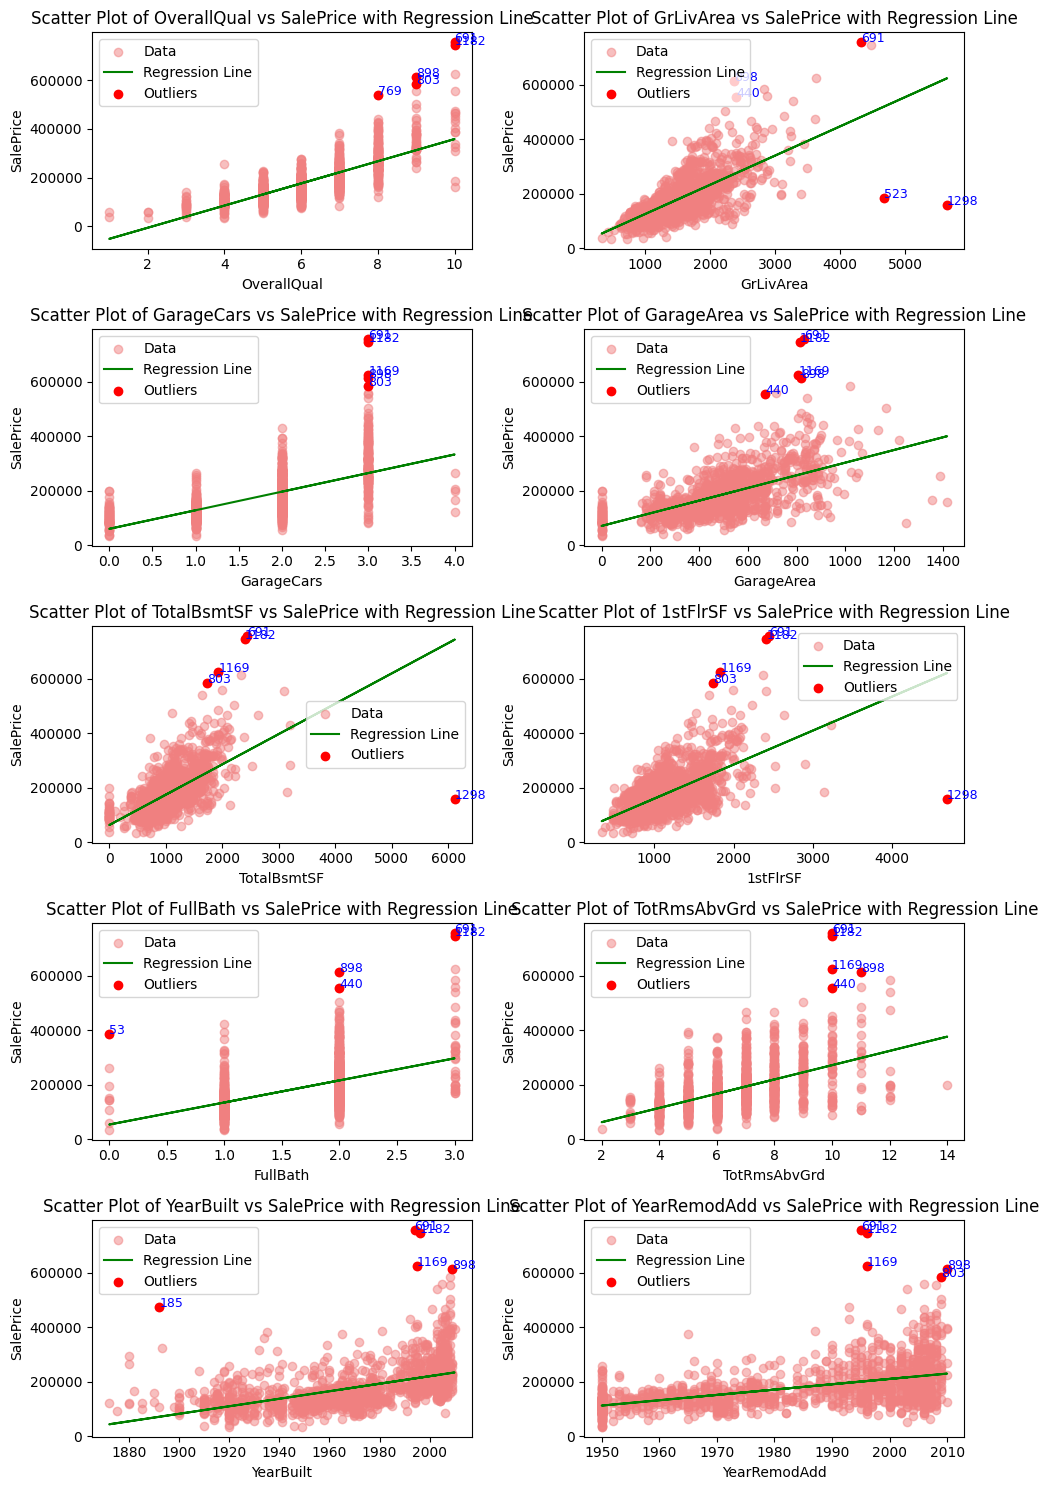

In [80]:
# Creating scatter plots, linear regression lines, and highlighting outliers with index numbers for the top 10 correlated features with SalePrice

fig, axes = plt.subplots(5, 2, figsize=(10, 15))
axes = axes.flatten()

for i, (feature, outlier_indices) in enumerate(outliers_indices_residuals_fixed.items()):
    # Preparing the feature and target data without NaN values
    feature_data = train[[feature, 'SalePrice']].dropna(subset=[feature, 'SalePrice'])
    X = feature_data[[feature]]
    y = feature_data['SalePrice']

    # Creating a linear regression model and fitting
    model = LinearRegression()
    model.fit(X, y)

    # Predicting the SalePrice for the regression line
    predictions = model.predict(X)

    # Plotting all data points
    axes[i].scatter(X, y, label='Data', alpha=0.5)

    # Plotting the regression line
    axes[i].plot(X, predictions, color='green', label='Regression Line')

    # Highlighting the outliers and annotating with index numbers
    for idx in outlier_indices:
        axes[i].scatter(X.loc[idx], y.loc[idx], color='red', label='Outliers' if idx == outlier_indices[0] else "")
        axes[i].text(X.loc[idx], y.loc[idx], str(idx), fontsize=9, color='blue')

    axes[i].set_title(f'Scatter Plot of {feature} vs SalePrice with Regression Line')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('SalePrice')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [97]:
outliers_indices_residuals_fixed

{'OverallQual': [691, 1182, 898, 769, 803],
 'GrLivArea': [1298, 898, 523, 440, 691],
 'GarageCars': [691, 1182, 1169, 898, 803],
 'GarageArea': [691, 1182, 1169, 898, 440],
 'TotalBsmtSF': [1298, 691, 1182, 1169, 803],
 '1stFlrSF': [1298, 691, 1182, 1169, 803],
 'FullBath': [691, 1182, 898, 440, 53],
 'TotRmsAbvGrd': [691, 1182, 1169, 898, 440],
 'YearBuilt': [691, 1182, 1169, 185, 898],
 'YearRemodAdd': [691, 1182, 1169, 898, 803]}

In [81]:
outliers = []
for li in outliers_indices_residuals_fixed.values():
  outliers.extend(li)
outliers = list(set(outliers))
outliers

[769, 898, 803, 523, 1169, 1298, 691, 53, 440, 185, 1182]

In [82]:
train.shape

(1460, 81)

In [83]:
train_eliminated = train.copy()
for outlier in outliers:
  train_eliminated = train_eliminated.drop(outlier)
# 外れ値を削除した結果を確認
train_eliminated.shape

(1449, 81)

# スコアの確認

In [98]:
all_data_outlier = pd.concat([train_eliminated, test], axis=0)

In [99]:
target = "SalePrice"
feature_cols = all_data_outlier.columns.drop(target)

all_data_outlier["MSSubClass"] = all_data_outlier["MSSubClass"].astype("object")

categorical_cols = []
numerical_cols = []
for i in feature_cols:
    if all_data_outlier[i].dtype=='object':
        categorical_cols.append(i)
    else:
        numerical_cols.append(i)

print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))
print(categorical_cols)
print(numerical_cols)

Number of categorical features: 44
Number of numerical features: 36
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'Gara

In [89]:
def feature_engineering(data):
  # add new feature
  data["YearSinceRemodel"] = data["YrSold"] - data["YearBuilt"] # ここで新しい特徴量を追加する
  data['BsmtFinType1_Unf'] = 1*(data['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
  data['HasWoodDeck'] = (data['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
  data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond'] # ここで新しい特徴量を追加する
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] # ここで新しい特徴量を追加する
  data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  data['YrBltAndRemod'] = data['YearBuilt'] + data['YearRemodAdd']
  data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
  data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
  data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

  # delete features
  data = data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
  return data

In [94]:
from sklearn.preprocessing import FunctionTransformer
# FunctionTransformerを用いてnp.log1pを適用するtransformerを作成
log_transformer = FunctionTransformer(np.log1p)

In [95]:
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data_outlier.copy()
all_data_fe["SalePrice"] = np.log1p(all_data_fe["SalePrice"])

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ("power", log_transformer)])
#skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=0.001, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_lgbm = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor(objective='regression', num_leaves=4,learning_rate=0.01, n_estimators=6000,
                          max_bin=200, bagging_fraction=0.75,bagging_freq=5, bagging_seed=7,
                          feature_fraction=0.2,feature_fraction_seed=7,verbose=-1))
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline_lgbm, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LGBM score: 0.1163 (0.0103)



In [96]:
pipeline_lgbm.fit(train_X, train_y)
preds = np.expm1(pipeline_lgbm.predict(test_X))
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': preds})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


,Id,SalePrice
0,1461,124830.412242
1,1462,158800.922088
2,1463,179150.312063
3,1464,189361.021149
4,1465,187370.424547
...,...,...
1454,2915,83125.637166
1455,2916,79727.905008
1456,2917,158837.597057
1457,2918,120099.243861


# メインから外れるコード

## データの概形確認

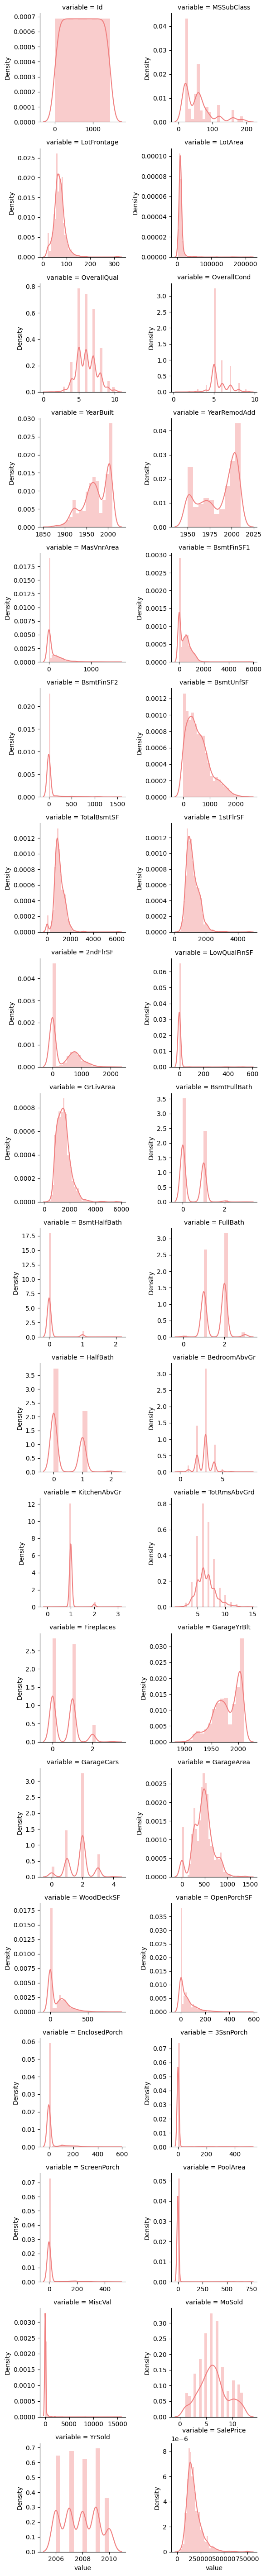

In [ ]:
f = pd.melt(train, value_vars=numerical_cols)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")